In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from nltk.corpus import wordnet as wn

from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectPercentile, SelectKBest, SelectFpr, chi2, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.impute import  SimpleImputer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from mlxtend.classifier import StackingCVClassifier

from tqdm import tqdm,trange
from collections import defaultdict,Counter
from text_to_num import text2num,alpha2digit
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

import os
import re
import time
import pickle
import scipy
import nltk
import warnings
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to C:\Users\HP OMEN
[nltk_data]     15\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\HP OMEN
[nltk_data]     15\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HP OMEN 15\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [86]:
data = pd.read_csv("COMP30027_2021_Project2_datasets\\input\\train_seconds.csv").sample(200)

In [ ]:
def verb(surface): 
    return 'v' in set(s.pos() for s in wordnet.synsets(surface))

text = " ".join([w for w in tqdm(data.steps,desc='Merging steps', position=0)])
text = " ".join([w for w in tqdm(text.split(), desc='Filtering out non-verbs', position=0) if verb(w)])

wc = WordCloud().generate(text)
plt.figure(figsize=(20,20))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

In [28]:
nltk.pos_tag('fill the rest with lychee juice'.split())

[('fill', 'VB'),
 ('the', 'DT'),
 ('rest', 'NN'),
 ('with', 'IN'),
 ('lychee', 'JJ'),
 ('juice', 'NN')]

In [93]:
def get_verbs(step):
    tags = nltk.pos_tag(step.split())
    return [tag[0] for tag in filter(lambda w: 'V' in w[1], tags)]

lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(re.sub(r'[^a-zA-Z0-9]',r'',word),'v') for word in text.split()])
def lemmatize_steps(steps):
    return [lemmatize_text(text) for text in steps]

In [84]:
re.sub(r'[^a-zA-Z0-9]',r'','ain\'t shit')

'aintshit'

In [95]:
data.steps.apply(lemmatize_text)[36055]

'have all the ingredients at room temperature position a rack in the lower third of oven and preheat to 325f thoroughly grease and flour a rise bundt pan sift together the flour  bake soda and salt set aside in the bowl of an electric mixer fit with the flat beater  beat the butter and cream cheese on medium speed until creamy and smooth gradually add the granulate sugar and beat until light and fluffy  about 5 min  occasionally scrap down the side of the bowl increase the speed to medhigh and add the egg one at a time  beat well after each addition  and scrap down the side of the bowl beat in the vanilla and lime juice reduce the mix speed to low and add the flour mixture in three additions  beat each addition until just incorporate stop the mixer occasionally to scrape down the side of the bowl use a rubber spatula  stir in the lime zest spoon the batter into the prepare pan  make the side about 1 inch higher than the center bake until the cake be golden and a toothpick insert into t

In [94]:
data.steps.apply(get_verbs)[36055]

["['have",
 'flour',
 'rose',
 'baking',
 "'in",
 'fitted',
 'beat',
 'add',
 'scraping',
 "'increase",
 'add',
 'beating',
 'scraping',
 "'reduce",
 'mixing',
 'add',
 'beating',
 "incorporated',",
 'scrape',
 "'using",
 'making',
 'is',
 'inserted',
 'comes',
 'cooled',
 "sugar']"]

Merging steps: 100%|██████████| 200/200 [00:01<00:00, 160.21it/s]


Text(0.5, 1.0, 'Verb cloud')

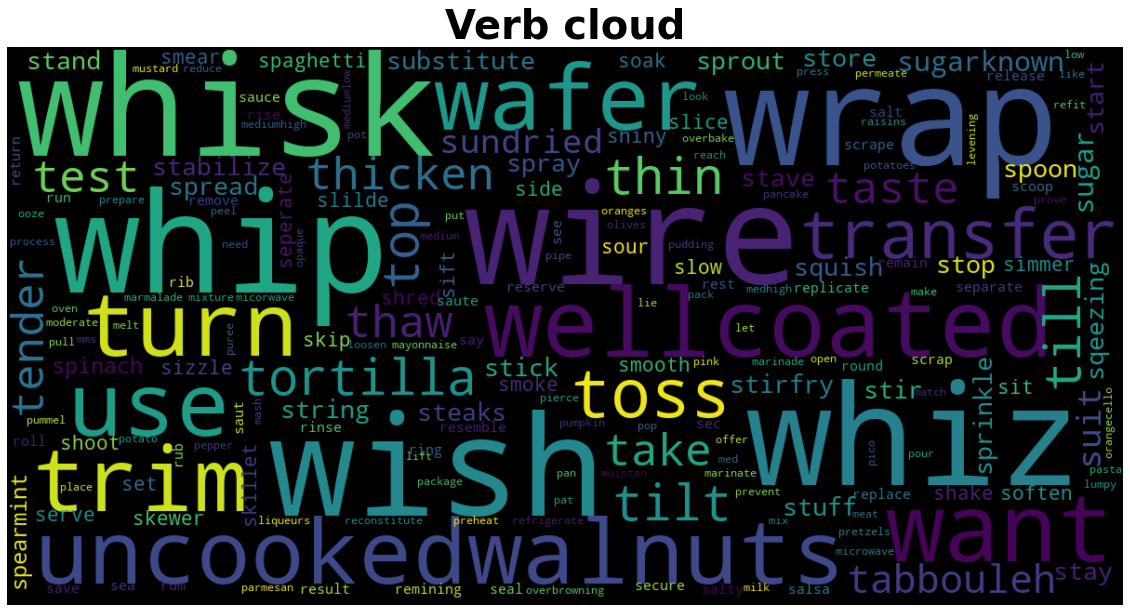

In [103]:
vlist = [w for step in [get_verbs(w) for w in tqdm(data.steps.apply(lemmatize_text),desc='Merging steps', position=0)] for w in step]
text = " ".join(vlist)
vc = CountVectorizer().fit(vlist)
wc = WordCloud(background_color='black',max_font_size=50,scale=3,random_state=1).fit_words(vc.vocabulary_)#.generate(text)
plt.figure(figsize=(20,20))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Verb cloud",fontdict={'fontsize':40, 'fontweight':'bold', 'verticalalignment': 'top'})

In [88]:
sorted(wc.words_.items(), key = lambda x:x[1], reverse=True)[:20]

[('add', 1.0),
 ('serve', 0.29850746268656714),
 ('remove', 0.26865671641791045),
 ('bake', 0.26865671641791045),
 ('make', 0.2537313432835821),
 ('cook', 0.23880597014925373),
 ('set', 0.21393034825870647),
 ('pour', 0.1691542288557214),
 ('combine', 0.16417910447761194),
 ('stir', 0.15422885572139303),
 ('mix', 0.14925373134328357),
 ('cool', 0.11940298507462686),
 ('cut', 0.11940298507462686),
 ('put', 0.11940298507462686),
 ('leave', 0.10945273631840796),
 ('use', 0.10945273631840796),
 ('reduce', 0.1044776119402985),
 ('sprinkle', 0.09950248756218906),
 ('chicken', 0.09950248756218906),
 ('brown', 0.09950248756218906)]

In [101]:
sorted(vc.vocabulary_, key = lambda x:x[1], reverse=True)[:20]

['extrude',
 'oven',
 'evaporate',
 'overbrowning',
 'overbake',
 'sugar',
 'cut',
 'put',
 'turn',
 'lumpy',
 'rub',
 'run',
 'pummel',
 'substitute',
 'pudding',
 'cup',
 'pull',
 'sundried',
 'mustard',
 'butter']